# Savitzky–Golay Filter — Summary  

## 📌 Purpose  
A digital filter used to **smooth noisy data** while preserving important features like **peaks, widths, and areas** better than standard moving averages.  

## ⚙️ How it works  
- Fits a low-degree **polynomial** to a moving window of data points using least squares.  
- The central point is replaced with the value from this polynomial fit.  
- Repeated for all points in the signal.  


## ✅ Advantages  
- Smooths while preserving peaks, slopes, and integrals.  
- Simple and efficient to compute.  

## ⚠️ Limitations  
- Not ideal for signals with sharp discontinuities.  
- Choice of parameters (window length & polynomial order) is critical.  
- Edge effects occur unless padding strategies are used.  

## 📊 Typical usage  
- **Window length:** odd number, often 5–25 points.  
- **Polynomial order:** 2–4.  


In [3]:
# library loading
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import rioxarray
import zarr
import pandas as pd

## 🔑 Key Parameters  
- **Window length (frame size):** Number of data points in each fit.  
  - Larger → stronger smoothing, but may distort fast features.  
- **Polynomial order:** Degree of the fitted polynomial.  
  - Higher order preserves curvature/details but can follow noise.  
  - Lower order yields smoother results.  
- **Mode (padding strategy):** Handles edges (`mirror`, `constant`, `nearest`, `wrap`).  

In [ ]:
# choose of paramters
pixel = 32
param_iqr = 1.5
upper_iqr = 0.6
bottom_iqr = 0.4
tau = 10.0  # larger tau = slower adaptation, more smoothing MUST be a float


data creation and preparation (run and ignore the following code)

In [5]:
ds = xr.open_zarr("/home/francesco/data_scratch/swiss-ndvi-processing/sample_seasonal_cycle_parameter_preds.zarr")
ndvi = ds['ndvi']
dates = ds['dates']

params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)

df = pd.DataFrame({
    'date': dates_pd
})

# Sort by date
df_sorted = df.sort_values(by='date')

# Extract the sorted arrays if needed
dates_sorted = df_sorted['date'].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values

doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE

# Define the double logistic function
def double_logistic_function(t, params):
    sos, mat_minus_sos, sen, eos_minus_sen, M, m = torch.split(params, 1, dim=1)
    mat_minus_sos = torch.nn.functional.softplus(mat_minus_sos)
    eos_minus_sen = torch.nn.functional.softplus(eos_minus_sen)
    sigmoid_sos_mat = torch.nn.functional.sigmoid(
        -2 * (2 * sos + mat_minus_sos - 2 * t) / (mat_minus_sos + 1e-10)
    )
    sigmoid_sen_eos = torch.nn.functional.sigmoid(
        -2 * (2 * sen + eos_minus_sen - 2 * t) / (eos_minus_sen + 1e-10)
    )
    return (M - m) * (sigmoid_sos_mat - sigmoid_sen_eos) + m


# caclulate lower and upper bonds
lower = double_logistic_function(t[[0]], params_lower[[pixel]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[pixel]]).squeeze().cpu().numpy()
# initialize outlier flag
outlier_arr = np.repeat(False,len(dates))

# extract ndvi 
ndvi_timeseries = ndvi[pixel, :]

# normalization
ndvi_timeseries = ndvi_timeseries / 10000

# assign cloud mask as nan
ndvi_timeseries = np.where((ndvi_timeseries > 1) | (ndvi_timeseries < 0), np.nan, ndvi_timeseries)
dates_pd = pd.to_datetime(dates)

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_timeseries
    })

df_sorted = df.sort_values(by='date')

dates_sorted = df_sorted['date'].values
ndvi_sorted = df_sorted['ndvi'].values

# initialize ndvi gapfilled
ndvi_gapfilled = np.copy(ndvi_sorted)

valid_idx = np.where(np.isfinite(ndvi_sorted))
valid_ndvi = ndvi_sorted[valid_idx]
valid_idx = np.array(valid_idx[0])
valid_upper = upper[valid_idx]
valid_lower = lower[valid_idx]

iqr = upper - lower
valid_iqr = valid_upper - valid_lower

median = upper - iqr / 2
median_valid = valid_upper - valid_iqr / 2

#######################
## outlier detection ##
#######################

# calculate threshold
delta_threshold_upper = valid_upper + param_iqr * valid_iqr
delta_threshold_lower = valid_lower - param_iqr * valid_iqr

# outlier detection by threshold

deltas = []
is_outlier_threshold = []

for i in range(0,len(valid_idx)):

    if valid_ndvi[i] > valid_upper[i]:

            delta = valid_ndvi[i] - valid_upper[i]

            if valid_ndvi[i] > delta_threshold_upper[i]:
                
                outlier = True
            else:
                outlier = False
    
    elif (valid_ndvi[i] < valid_upper[i]) and (valid_ndvi[i] > valid_lower[i]):
          
        delta = valid_ndvi[i] - (valid_upper[i] - valid_iqr[i])
        outlier = False

    else:
            delta = valid_ndvi[i] - valid_lower[i]

            if valid_ndvi[i] < delta_threshold_lower[i]:
                 
                 outlier = True
            else:
                 outlier = False

    deltas.append(delta)
    is_outlier_threshold.append(outlier)
    
is_outlier_threshold = np.array(is_outlier_threshold)
deltas = np.array(deltas)

# outlier detection by deltas neighbour
# the deltas are calculated based on the neaster bound

delta_delta_left = (deltas[1:] - deltas[:-1]) 
delta_delta_right = (deltas[:-1] - deltas[1:]) 

delta_delta_left = np.array(delta_delta_left)
delta_delta_right = np.array(delta_delta_right)


slope_is_outlier = np.logical_and(
        
        np.logical_or(delta_delta_left[1:] > np.quantile(delta_delta_left,upper_iqr), 
                      delta_delta_left[1:]  <  np.quantile(delta_delta_left,bottom_iqr)),

        np.logical_or(delta_delta_right[:-1]  > np.quantile(delta_delta_right,upper_iqr), 
                      delta_delta_right[:-1]  < np.quantile(delta_delta_right,bottom_iqr))
    )


# to be an outlier, a point must met both conditions
is_outlier = np.logical_and(is_outlier_threshold[1:-1],slope_is_outlier)

# write the outlier in the new data
outlier_arr[valid_idx[1:-1]] = is_outlier

# outlier detection first and last
if np.logical_and(
     
     np.logical_or(
        delta_delta_right[0] >= np.quantile(delta_delta_right,upper_iqr), 
        delta_delta_right[0] <= np.quantile(delta_delta_right,bottom_iqr)
        ),
        
        is_outlier_threshold[0]):

    outlier_arr[valid_idx[0]] = True
    ndvi_gapfilled[valid_idx[0]] = np.nan

if np.logical_and(
                 
        np.logical_or(
            delta_delta_left[-1] >= np.quantile(delta_delta_left,upper_iqr), 
            delta_delta_left[-1] <= np.quantile(delta_delta_left,bottom_iqr)
            ),
            
            is_outlier_threshold[-1]) == True:


    outlier_arr[valid_idx[-1]] = True
    ndvi_gapfilled[valid_idx[-1]] = np.nan

#######################
## linear gapfilling ##
#######################

to_remove = valid_idx[1:-1][is_outlier == True]
ndvi_gapfilled[to_remove] = np.nan

valid_idx = np.where(np.isfinite(ndvi_gapfilled))
valid_idx = np.array(valid_idx[0])

distances = valid_idx[1:] - valid_idx[:-1]  

for i in range(0,len(valid_idx)-1):

    idx_to_gapfill = range(valid_idx[i]+1,valid_idx[i+1])
    idx_to_gapfill = np.array(idx_to_gapfill)

    if len(idx_to_gapfill) != 0: # if len == 0 means 2 contigous obs data

        multiplier = range(1,len(idx_to_gapfill)+1)
        multiplier = np.array(multiplier)

        # gapfill based on the median

        delta_1 = ndvi_gapfilled[valid_idx[i]] - median[valid_idx[i]] 
        delta_2 = ndvi_gapfilled[valid_idx[i+1]] - median[valid_idx[i+1]] 
        
        slope = (delta_2 - delta_1) / distances[i]

        values = (median[idx_to_gapfill] + delta_1 + slope * multiplier ) 

        ndvi_gapfilled[idx_to_gapfill] = values

/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


jsksljs

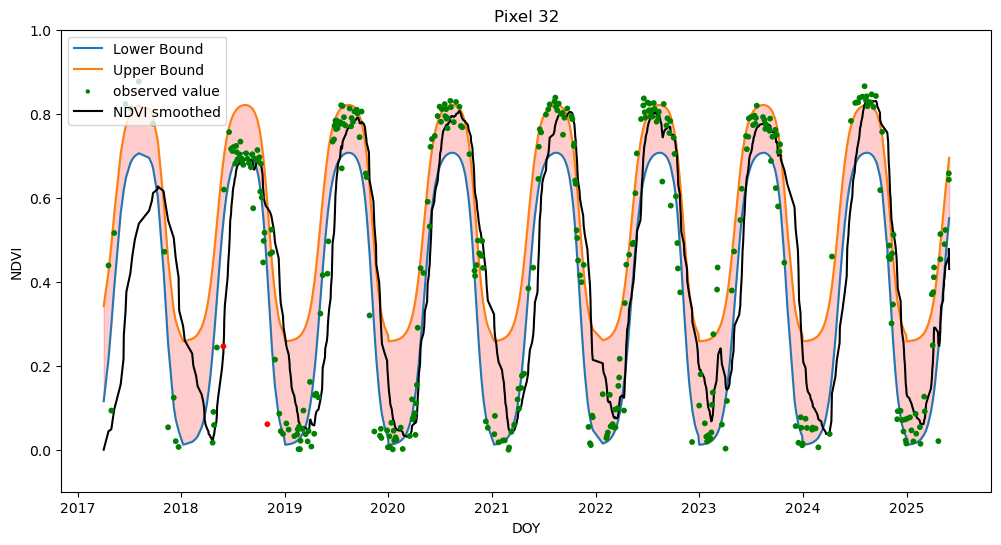

In [16]:
ndvi_gapfilled = np.nan_to_num(ndvi_gapfilled, nan=0.0)
smoothed_data = np.copy(ndvi_gapfilled)

s = np.zeros_like(smoothed_data)
s[0] = smoothed_data[0]  
for t in range(1, len(smoothed_data)):
    s[t] = s[t-1] + (1/tau) * (smoothed_data[t] - s[t-1])

smoothed_data = s

fig, ax = plt.subplots(figsize=(12, 6)) 

colors = np.where(outlier_arr, 'red', 'green')

ax.plot(dates_sorted, lower, label="Lower Bound")
ax.plot(dates_sorted, upper, label="Upper Bound")
ax.fill_between(dates_sorted, lower, upper, alpha=0.2, color="red")
ax.scatter(dates_sorted, ndvi_sorted, s=10, color=colors, label="observed value", zorder=3)
ax.plot(dates_sorted, s, color="black", label="NDVI smoothed")
ax.set_title(f"Pixel {pixel}")
ax.set_ylim(-0.1, 1)
ax.set_xlabel("DOY")
ax.set_ylabel("NDVI")
ax.legend()

plt.show()

In [15]:
smoothed_data = np.copy(ndvi_gapfilled)

s = np.zeros_like(smoothed_data)

print(s)

[0. 0. 0. ... 0. 0. 0.]
